In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn import linear_model, cross_validation
from sklearn import grid_search
import pylab as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
pd.set_option("precision", 2)
execfile("toolbox.py")

In [3]:
data = pd.read_csv("data_source/frankeinstein.csv", index_col=['code', 'year'])
print "Number of countries : ", len(data.index.levels[0])
original_variables = data.keys()
print data.info()

Number of countries :  127
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2861 entries, (AFG, 2007.0) to (ZMB, 2010.0)
Data columns (total 11 columns):
GDP_growth_WB                 2861 non-null float64
openness_WB                   2861 non-null float64
investments                   2861 non-null float64
years_schooling               2861 non-null float64
savings                       2861 non-null float64
gini                          2861 non-null float64
price_level_investment_PWT    2861 non-null float64
gov_consumption_WB            2861 non-null float64
inflation_WB                  2861 non-null float64
fertility_WB                  2861 non-null float64
GDP_PC                        2861 non-null float64
dtypes: float64(11)
memory usage: 268.2+ KB
None


In [4]:
continent_data = pd.read_csv("data_source/country_continent_code.csv",
                             index_col=['ISO 3166-1 alpha-3'], keep_default_na=False, na_values=['chaineimprobable'])

data["africa"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'AF')).values
data["latin_am"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'SA')).values
data["asia"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'AS')).values
data["oceania"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'OC')).values
data["europe"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'EU')).values
data["north_am"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'NA')).values

In [5]:
for var in original_variables:
    data['past_' +  var] = rolling_mean(data, var, 10, 5, how='past')
data = data.dropna(how='any')

In [16]:
for var in original_variables:
    data['var_' +  var] = growth(data, var, how='past')

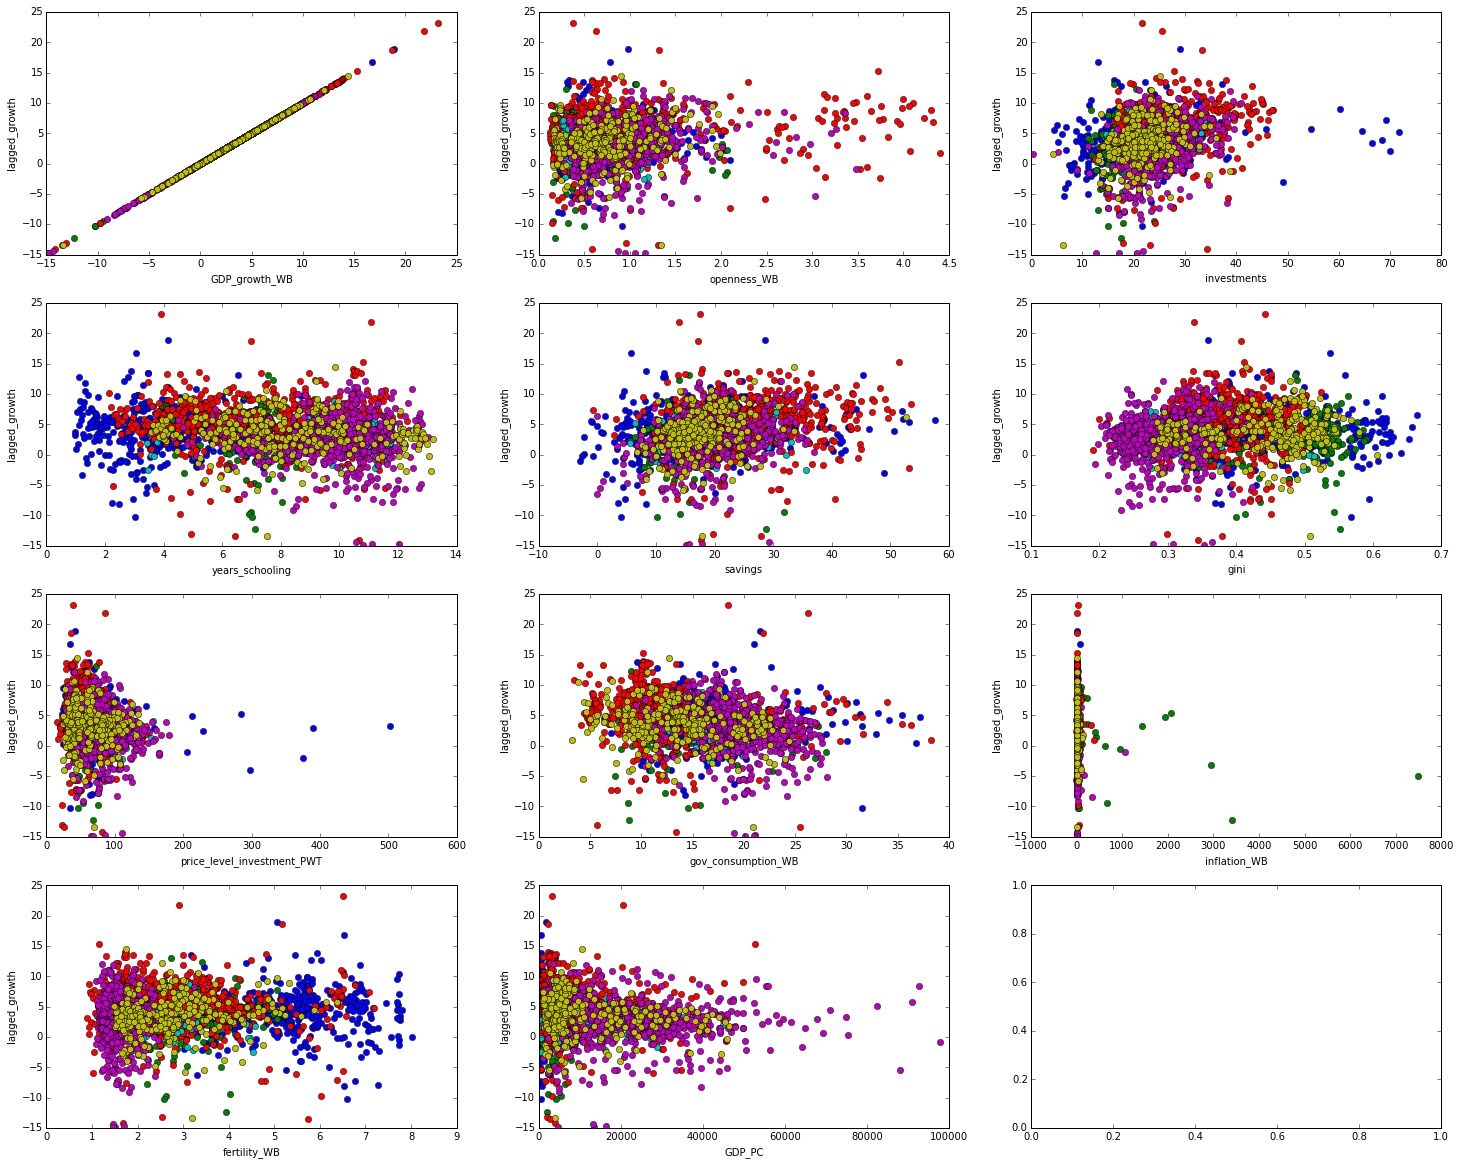

In [17]:
nbr_cols = 3
variables = original_variables
f, axarr = plt.subplots((len(original_variables) / nbr_cols)+1, nbr_cols, figsize=(25,20))
for n, var in enumerate(original_variables):
    i,j = n/nbr_cols, n%nbr_cols
    for cont in ['africa', 'latin_am', 'asia', 'oceania', 'europe', 'north_am']:
        sel_data = data[data[cont] == 1]
        axarr[i, j].plot(sel_data[var], sel_data['GDP_growth_WB'], 'o')
        axarr[i, j].set_xlabel(var)
        axarr[i, j].set_ylabel('lagged_growth')

In [32]:
print data['GDP_growth_WB'].values.shape
print data['past_savings'].values.shape

(2357,)
(2357,)


In [54]:
X = data[data['var_savings'].apply(lambda x: abs(x) < 15)][['savings']]
Y = data[data['var_savings'].apply(lambda x: abs(x) < 15)]['GDP_growth_WB']

clf = linear_model.LinearRegression()
clf.fit(X, Y)

plt.plot(X, Y, 'go')
plt.plot(X, clf.predict(X), 'b')

print clf.coef_

KeyError: 'var_savings'

Number of countries 100
Mean of coefficients -6.03014955685
Standard deviation 122.936342117
Skewness -0.412037575329


,coef
country,
SWZ,-6.8e+02


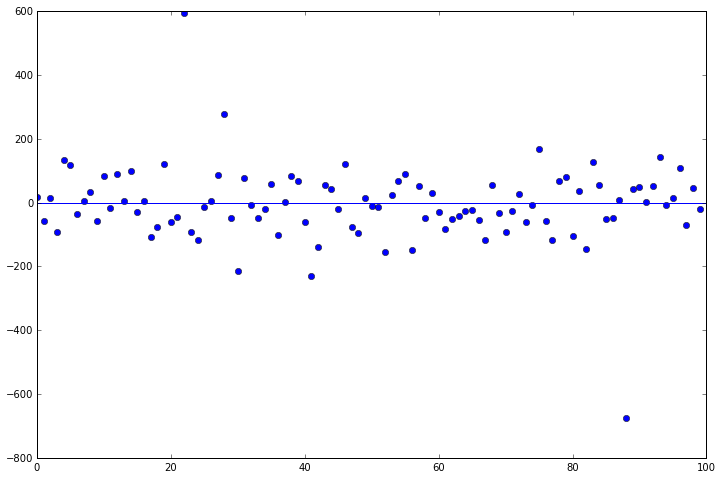

In [131]:
results = pd.DataFrame(columns=["country", "coef"])
results.set_index("country", inplace=True)
for country in data.index.levels[0]:
    X = data.loc[country][['gini']]
    Y = data.loc[country]['savings']
    if len(X) >= 10:
        clf = linear_model.LinearRegression()
        clf.fit(X, Y)
        results.loc[country, "coef"] = clf.coef_[0]
plt.figure(figsize=(12,8))        
plt.plot(results, 'o')
plt.axhline()

print "Number of countries", len(results)
print "Mean of coefficients", results.mean().values[0]
print "Standard deviation", results.std().values[0]
print "Skewness", results.skew().values[0]
results[results['coef'] == results['coef'].min()]

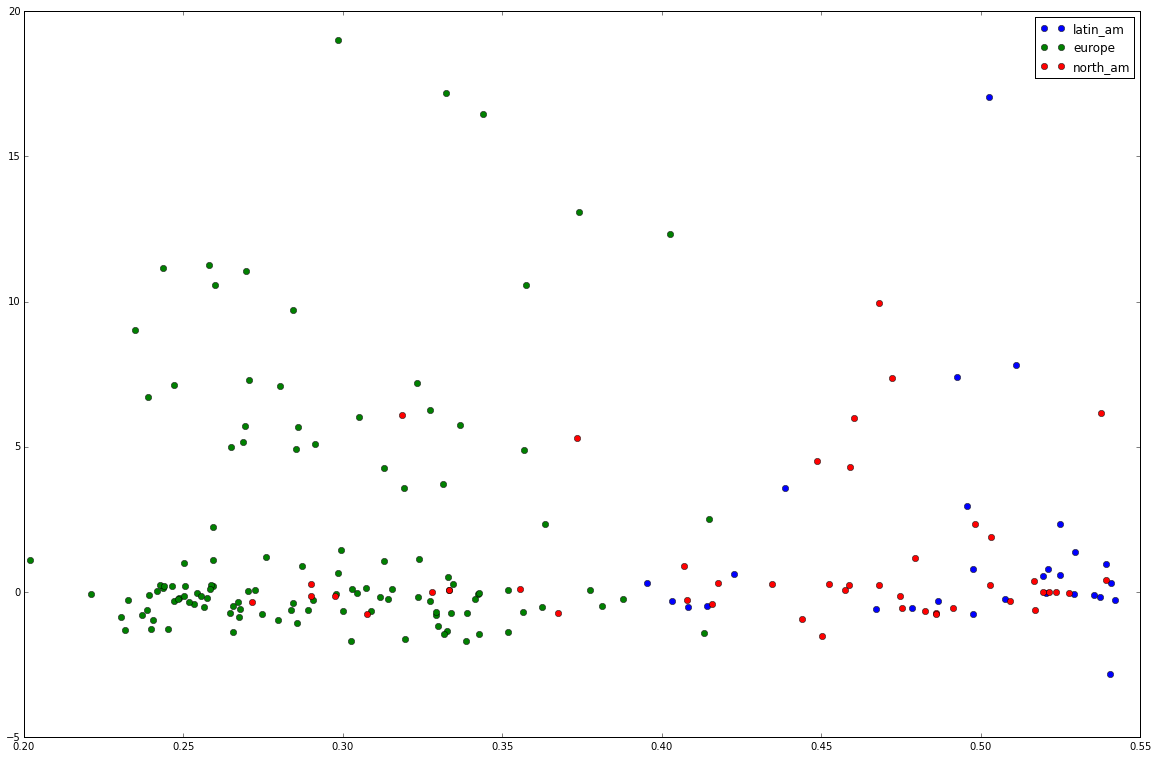

In [110]:
plt.figure(figsize=(20, 13))
#for cont in ['africa', 'latin_am', 'asia', 'oceania', 'europe', 'north_am']:
for cont in ['latin_am', 'europe', 'north_am']:
    sel_data = resample(data[data[cont] == 1], 10)
    plt.plot(sel_data['past_gini'], sel_data['var_GDP_growth_WB'], 'o', label=cont)
plt.legend()

# Using of private wealth share

In [49]:
var_choice = ["GDP_PC_PWT", "K_over_PIB", "savings_WB", 'gini_net_SWIID', 
              'gini_market_SWIID', 'price_level_investment_PWT', 'openness_WB', 'years_schooling']

data = pd.read_csv("data_source/all_data.csv", usecols=["year", "code"] + var_choice, index_col=['code', 'year']).dropna(how='all')

data.reset_index(inplace=True)
data.sort_values(['code', 'year'], inplace=True)
data.set_index(['code'], inplace=True)
new_frame = pd.DataFrame()
for country in set(data.index.values):
    sel = data.loc[country]
    if sel.shape != (len(var_choice) + 1,):
        try:
            sel.loc[:, 'years_schooling'] = sel['years_schooling'].interpolate()
        except TypeError:
            None
        new_frame = pd.concat([new_frame, sel])
data = new_frame.reset_index().set_index(['code', 'year'])
data["growth"] = growth(data, "GDP_PC_PWT", as_rate=True, how="futur") * 100
data['gini_var'] = growth(data, "gini_net_SWIID", how="past")
data['past_gini_var'] = rolling_mean(data, "gini_var", 10, 5, how='past', sum=True)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 505 entries, (DEU, 1972.0) to (JPN, 2010.0)
Data columns (total 11 columns):
savings_WB                    505 non-null float64
K_over_PIB                    505 non-null float64
GDP_PC_PWT                    505 non-null float64
years_schooling               505 non-null float64
openness_WB                   505 non-null float64
price_level_investment_PWT    505 non-null float64
gini_net_SWIID                505 non-null float64
gini_market_SWIID             505 non-null float64
growth                        505 non-null float64
gini_var                      505 non-null float64
past_gini_var                 505 non-null float64
dtypes: float64(11)
memory usage: 47.3+ KB


In [50]:
data.head(10)

savings_WB  K_over_PIB  GDP_PC_PWT  years_schooling  openness_WB  \
code year                                                                     
DEU  1972       28.39      221.78    14140.90             7.02         0.31   
     1973       27.65      218.48    14850.95             7.01         0.32   
     1974       25.37      220.13    14884.76             6.99         0.37   
     1975       22.20      229.47    14981.13             6.98         0.36   
     1976       22.68      228.68    15744.06             6.99         0.38   
     1977       22.36      236.45    16325.63             7.00         0.38   
     1978       23.33      245.75    17017.92             7.01         0.37   
     1979       23.24      248.60    17696.45             7.02         0.39   
     1980       21.99      252.68    17710.69             7.03         0.42   
     1981       19.85      261.20    17151.85             7.06         0.44   

           price_level_investment_PWT  gini_net_SWIID  gini_market_SWIID  \
code year                                                                  
DEU  1972                       82.29            0.28               0.42   
     1973                       94.87            0.27               0.38   
     1974                       96.78            0.28               0.42   
     1975                       96.57            0.29               0.43   
     1976                       91.46            0.28               0.43   
     1977                       97.59            0.27               0.43   
     1978                      108.00            0.26               0.41   
     1979                      114.22            0.26               0.43   
     1980                      114.91            0.27               0.46   
     1981                       91.05            0.24               0.41   

           growth  gini_var  past_gini_var  
code year                                   
DEU  1972    5.02 -2.09e-04          -0.02  
     1973    0.23 -9.82e-03          -0.03  
     1974    0.65  1.06e-02          -0.02  
     1975    5.09  6.22e-03          -0.01  
     1976    3.69 -7.31e-03          -0.02  
     1977    4.24 -7.73e-03          -0.03  
     1978    3.99 -1.13e-02          -0.05  
     1979    0.08  1.67e-03          -0.02  
     1980   -3.16  9.94e-03          -0.04  
     1981   -1.68 -3.03e-02          -0.04

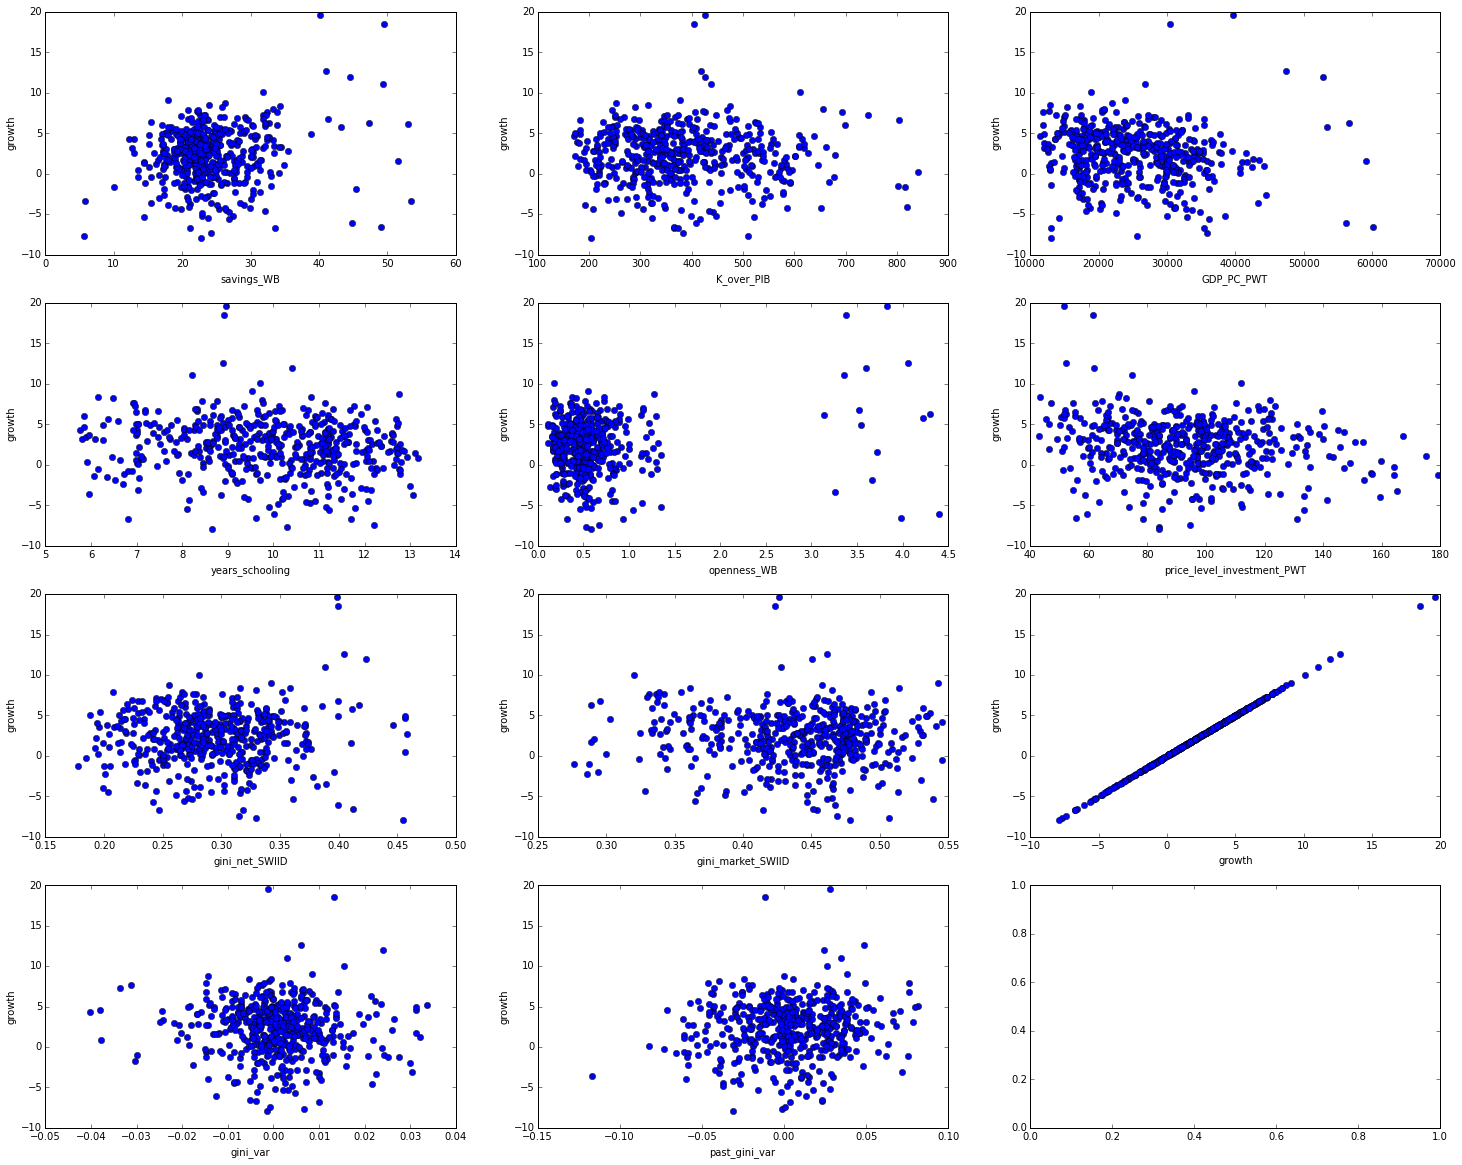

In [53]:
nbr_cols = 3
f, axarr = plt.subplots((len(data.keys()) / nbr_cols)+1, nbr_cols, figsize=(25,20))
for n, var in enumerate(data.keys()):
    i,j = n/nbr_cols, n%nbr_cols
    axarr[i, j].plot(data[var], data['growth'], 'o')
    axarr[i, j].set_xlabel(var)
    axarr[i, j].set_ylabel('growth')

In [11]:
country = 'CHN'
clf = linear_model.LinearRegression()
clf.fit(data.loc[country][['years_schooling']], data.loc[country]["GDP_PC"])
plt.plot(data.loc[country]['years_schooling'], data.loc[country]["GDP_PC"], 'o')
plt.plot(data.loc[country]['years_schooling'], clf.predict(data.loc[country][['years_schooling']]))
print "R**2 = ", clf.score(data.loc[country][['years_schooling']], data.loc[country]["GDP_PC"])
print "Coefficient = ", clf.coef_[0]

KeyError: 'the label [CHN] is not in the [index]'